Problem Definition: The goal of this project is to create a sentiment analysis model that can classify movie reviews as either positive or negative based on their content. 

In [32]:
!pip install pandas scikit-learn matplotlib seaborn nltk wordcloud textblob


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: C:\Users\maghr\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [33]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from textblob import TextBlob


The read_reviews function will loop through the Imdb directory and aggregate the training and testing data into two lists.
We collect our list of training reviews and corresponding sentiments, as well as the testing data, and load them into panda dataframes.

In [34]:
def read_reviews(data_dir):
    reviews = []
    sentiments = []

    for sentiment in ['pos', 'neg']:
        sentiment_dir = os.path.join(data_dir, sentiment)
        for filename in os.listdir(sentiment_dir):
            with open(os.path.join(sentiment_dir, filename), 'r', encoding='utf-8') as f:
                reviews.append(f.read())
                sentiments.append(sentiment)
    return reviews, sentiments

train_data_dir = 'data/aclImdb/train'
train_reviews, train_sentiments = read_reviews(train_data_dir)

test_data_dir = 'data/aclImdb/test'
test_reviews, test_sentiments = read_reviews(test_data_dir)

train_df = pd.DataFrame({'review': train_reviews, 'sentiment':train_sentiments})
test_df = pd.DataFrame({'review': test_reviews, 'sentiment': test_sentiments})

print(train_df.head())
print(test_df.head())

                                              review sentiment
0  Bromwell High is a cartoon comedy. It ran at t...       pos
1  Homelessness (or Houselessness as George Carli...       pos
2  Brilliant over-acting by Lesley Ann Warren. Be...       pos
3  This is easily the most underrated film inn th...       pos
4  This is not the typical Mel Brooks film. It wa...       pos
                                              review sentiment
0  I went and saw this movie last night after bei...       pos
1  Actor turned director Bill Paxton follows up h...       pos
2  As a recreational golfer with some knowledge o...       pos
3  I saw this film in a sneak preview, and it is ...       pos
4  Bill Paxton has taken the true story of the 19...       pos


Now that we have our dataframes, it's time to explore the data. Unlike the data containing continuous numerical features in our wine and flower classifiers, we instead of text-based data.
We will analyze the top-n most frequent words in both positive and negative reviews.
So we must preprocess the text data by tokenizing, removing stop words, applying lemmatization
Then we will create frequency distributions for both positive and negative reviews
Finally we will be able to visualize the top-n most frequent words for both positive and negative reviews

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maghr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maghr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\maghr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


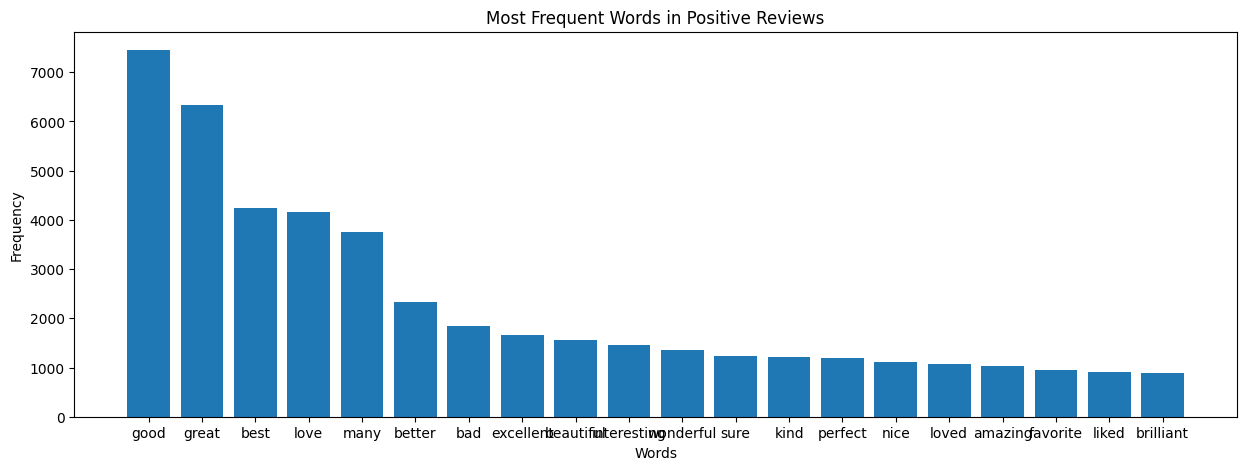

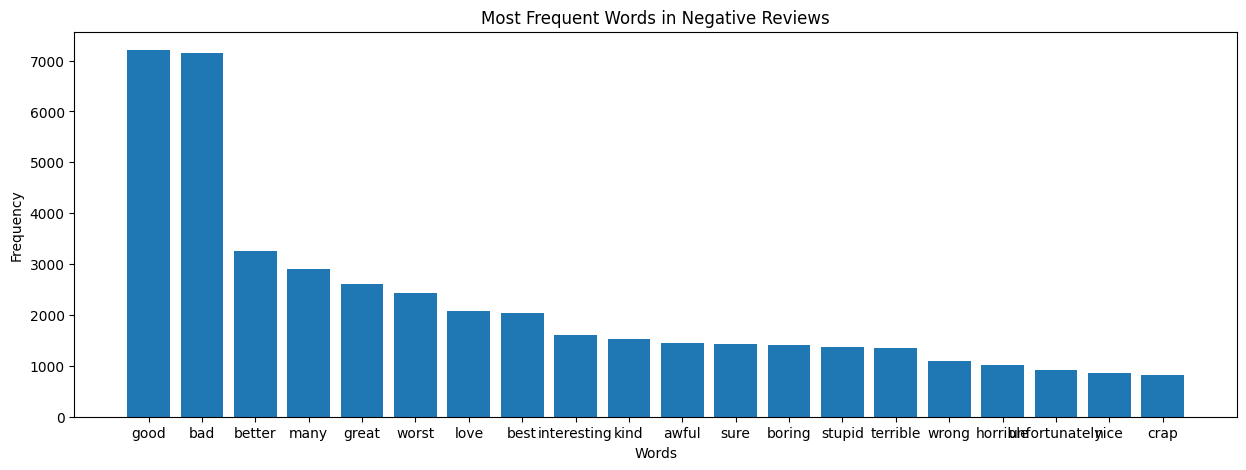

In [35]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

#Tokenize, remove stopwords, lemmatize input text
def preprocess_text(text):
    words = nltk.word_tokenize(text.lower())

    stop_words = set(stopwords.words('english'))
    filtered_words = []
    for word in words:
        if word.isalnum() and word not in stop_words:
            filtered_words.append(word)
    words = filtered_words

    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    for word in words:
        if abs(TextBlob(word).sentiment.polarity) > 0.4:
            lemmatized_word = lemmatizer.lemmatize(word)
            lemmatized_words.append(lemmatized_word)
    words = lemmatized_words

    return words

positive_reviews = train_df[train_df['sentiment'] == 'pos']['review']
negative_reviews = train_df[train_df['sentiment'] == 'neg']['review']

positive_words = []
for review in positive_reviews:
    preprocessed_review = preprocess_text(review)
    for word in preprocessed_review:
        positive_words.append(word)

negative_words = []
for review in negative_reviews:
    preprocessed_review = preprocess_text(review)
    for word in preprocessed_review:
        negative_words.append(word)

positive_word_freq = Counter(positive_words)
negative_word_freq = Counter(negative_words)

#Visualize top-n most frequent words for positive and negative reviews with matplotlib
def plot_word_freq(word_freq, n, title):
    top_n_words = word_freq.most_common(n)
    words, frequencies = zip(*top_n_words)
    plt.figure(figsize=(15, 5))
    plt.bar(words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()


n = 20  # amount of top words we want to visualize
plot_word_freq(positive_word_freq, n, 'Most Frequent Words in Positive Reviews')
plot_word_freq(negative_word_freq, n, 'Most Frequent Words in Negative Reviews')

We find that many of the top most frequent words have little sentimental value to the reviews. The most frequent word in both cases is the tokenized form of the HTML <br> tag
We will use TextBlob to determine the sentiment polarity of each word, and use that information to decide which words will be appended to our stop words.

In [36]:
top_20_positive_words = {'br', 'film', 'movie', 'one', 'like', 'time', 'good', 'story', 'character', 'great', 'see', 'get', 'would', 'well', 'make', 'also', 'really', 'even', 'scene', 'show'}

for word in top_20_positive_words:
    sentiment = TextBlob(word).sentiment.polarity
    print(f"{word}: {sentiment}")

one: 0.0
see: 0.0
well: 0.0
film: 0.0
good: 0.7
time: 0.0
even: 0.0
get: 0.0
character: 0.0
movie: 0.0
would: 0.0
br: 0.0
show: 0.0
also: 0.0
story: 0.0
scene: 0.0
great: 0.8
like: 0.0
really: 0.2
make: 0.0


After seeing this output we can adjust the code in our preprocess_text function to filter out words with a polarity below a given threshold.